# Bayesian Model Calibration

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import scipy.stats
from tqdm import tqdm
from scipy.integrate import odeint
from scipy.optimize import minimize
from IPython.display import display, Math
from scipy.optimize import Bounds

## Defining the model
Let N be the number of tumor cells and assume that this number can increase with a growth rate of $r$ cells/hour until it reaches the environmental carrying capacity of $K$ cells. With these assumptions, the mathematical model is:
\begin{equation}
\frac{dN}{dt}=rN\left(1-\frac{N}{K}\right),
\end{equation}

- $\boldsymbol{\theta}$: vector of model parameters, $\boldsymbol{\theta}=(r,K)$;
- $r$: tumor growth rate;
- $K$: environmental carrying capacity;
- $\boldsymbol{Y}(\boldsymbol{\theta})$: model prediction;

In [2]:
# Let y be the vector of outputs, t the time, and theta the vector of parameters
def control_tumor(y, t, r, K):
    """
    Logistic growth model representing tumor growth.

    Parameters:
        y : array_like
            Array of dependent variables.
        t : float
            Independent variable (time).
        r : float
            Growth rate parameter.
        K : float
            Carrying capacity parameter.

    Returns:
        dydt : array_like
            Array of derivatives of y with respect to t.
    """
    dydt = r * y[0] * (1.0 - y[0] / K)
    return dydt

## Generating the data
We will generate the in silico data using the true model and adding a random perturbation

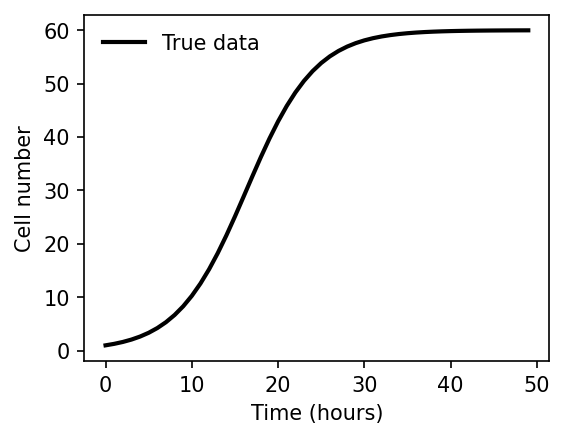

In [3]:
# Define time interval, parameter value, and initial condition
times = np.arange(50)  # Time points
true_r = 0.25  # True growth rate parameter
true_K = 60  # True carrying capacity parameter
true_ic = 1  # True initial condition

# Solving the ODE model
parameters = (true_r, true_K)  # Tuple of true parameter values
y = odeint(control_tumor, t=times, y0=true_ic, args=parameters)  # Solve the ODE

# Plotting the result
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
plt.plot(times, y, label='True data', color='black', linewidth=2.0)
plt.legend(frameon=False)
plt.xlabel('Time (hours)')
plt.ylabel('Cell number')
plt.show()

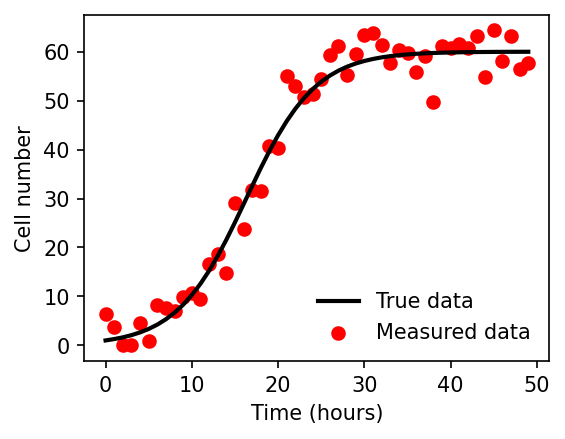

In [4]:
# Adding perturbation
true_sigma = 3.6  # Standard deviation of the noise
np.random.seed(2021)  # For reproducibility
yobs = np.random.normal(y, true_sigma)  # Add noise to the true data
yobs[yobs < 0] = 0  # Ensure non-negative values

# Plotting the true and observed data
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
plt.plot(times, y, label='True data', color='black', linewidth=2.0)
plt.scatter(times, yobs, label='Measured data', color='red')
plt.legend(frameon=False)
plt.xlabel('Time (hours)')
plt.ylabel('Cell number')
plt.savefig('just_data.pdf', bbox_inches='tight', pad_inches=0.02, dpi=150)
plt.show()

## Maximum likelihood estimation

Find $\hat{\boldsymbol{\theta}}\in\Theta$, where $\Theta$ is the parameter space, that maximize the likelihood.

It is customary to work with the more manageable log-likelihood function.

\begin{align*}
\hat{\boldsymbol{\theta}}&=\underset{\boldsymbol{\theta}\in\Theta}{\text{argmax}}[\log\pi(\boldsymbol{D}|\boldsymbol{\theta})];\\
&=\underset{\boldsymbol{\theta}\in\Theta}{\text{argmax}}\left[-\frac{1}{2}\sum_{i=1}^{N_t}\left(\log(2\pi)+\log(\sigma^2)+\frac{(D_{i}-Y_i(\boldsymbol{\theta}))^2}{\sigma^2}\right)\right].
\end{align*}

In [5]:
def log_likelihood(theta, times, y):
    """
    Compute the log-likelihood of the observed data given a set of parameters and a model.

    Parameters:
        theta : array_like
            Array of parameters including the standard deviation of the noise.
        times : array_like
            Array of time points.
        y : array_like
            Array of observed data.

    Returns:
        log_likelihood : float
            Log-likelihood of the observed data.
    """
    cal_sigma = theta[-1]  # Extract the standard deviation of the noise from theta
    parameters = tuple(theta[:-1])  # Extract other parameters from theta
    model = odeint(control_tumor, t=times, y0=y[0], args=parameters)  # Solve the ODE model with the given parameters
    variance = cal_sigma * cal_sigma  # Variance of the noise
    # Compute the log-likelihood
    log_likelihood = -0.5 * np.sum((y.ravel() - model.ravel()) ** 2 / variance + np.log(2*np.pi) + np.log(variance))
    return log_likelihood

In [6]:
# Define negative log-likelihood function
nll = lambda *args: -log_likelihood(*args)

# Labels for parameters
labels = ["Growth Rate", "Carrying Capacity", "Standard Deviation"]

# Lower and upper bounds for parameters
l_bound = [0.0, 10.0, 0.10]  # Lower bounds
u_bound = [1.0, 120., 50.0]  # Upper bounds

# Get the number of dimensions
ndim = len(l_bound)

# Initialize the position array for walkers
initial = np.zeros(ndim)

# Generate initial positions for walkers within the specified bounds
for i in range(ndim):
    initial[i] = np.random.uniform(low=l_bound[i], high=u_bound[i])

# Define bounds for optimization
bounds = Bounds(l_bound, u_bound)

# Minimize the negative log-likelihood
soln = minimize(nll, initial, args=(times, yobs), bounds=bounds)
ml_r, ml_K, ml_sigma = soln.x  # Maximum likelihood estimates

# Print maximum likelihood estimates
print("Maximum likelihood estimates:")
print("Growth rate = %f" % ml_r)
print("Carrying capacity = %f" % ml_K)
print("Standard deviation = %f" % ml_sigma)

# Calculate percentage errors
error_r = 100 * abs(ml_r - true_r) / true_r
error_K = 100 * abs(ml_K - true_K) / true_K
error_sigma = 100 * abs(ml_sigma - true_sigma) / true_sigma

# Print percentage errors
print("Growth rate %% error = %f" % error_r)
print("Carrying capacity %% error = %f" % error_K)
print("Standard deviation %% error = %f" % error_sigma)

Maximum likelihood estimates:
Growth rate = 0.138938
Carrying capacity = 63.533237
Standard deviation = 6.289257
Growth rate % error = 44.424921
Carrying capacity % error = 5.888729
Standard deviation % error = 74.701579


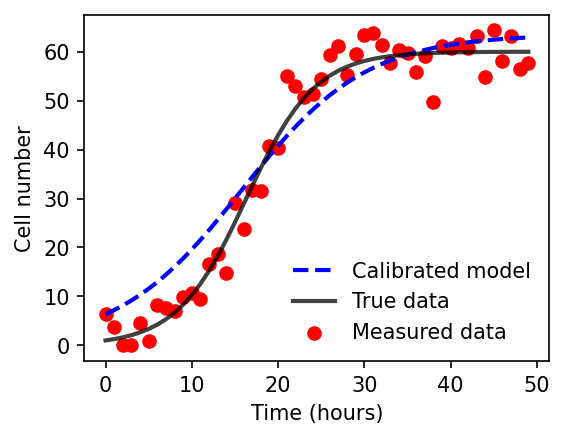

In [7]:
# Define parameters using maximum likelihood estimates
parameters = (ml_r, ml_K)

# Solve the ODE model with maximum likelihood parameter estimates
y_ml = odeint(control_tumor, t=times, y0=yobs[0], args=parameters)

# Plot the calibrated model, true data, and observed data
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
plt.plot(times, y_ml, label='Calibrated model', linestyle='dashed', color='blue', linewidth=2.0)
plt.plot(times, y, label='True data', color='black', alpha=0.75, linewidth=2.0)
plt.scatter(times, yobs, label='Measured data', color='red')
plt.legend(frameon=False)
plt.xlabel('Time (hours)')
plt.ylabel('Cell number')
plt.savefig('ml_fit.pdf', bbox_inches='tight', pad_inches=0.02, dpi=150)
plt.show()

In [8]:
def log_likelihood_ic(theta, times, y):
    """
    Compute the log-likelihood of the observed data given a set of parameters including the initial condition and a model.

    Parameters:
        theta : array_like
            Array of parameters including the standard deviation of the noise and the initial condition.
        times : array_like
            Array of time points.
        y : array_like
            Array of observed data.

    Returns:
        log_likelihood : float
            Log-likelihood of the observed data.
    """
    cal_sigma = theta[-1]  # Extract the standard deviation of the noise from theta
    cal_ic = theta[-2]  # Extract the initial condition from theta
    parameters = tuple(theta[:-2])  # Extract other parameters from theta
    model = odeint(control_tumor, t=times, y0=cal_ic, args=parameters)  # Solve the ODE model with the given parameters
    variance = cal_sigma * cal_sigma  # Variance of the noise
    # Compute the log-likelihood
    log_likelihood = -0.5 * np.sum((y.ravel() - model.ravel()) ** 2 / variance + np.log(2*np.pi) + np.log(variance))
    return log_likelihood

In [9]:
# Define negative log-likelihood function
nll = lambda *args: -log_likelihood_ic(*args)

# Labels for parameters
labels = ["Growth Rate", "Carrying Capacity", "Initial Condition", "Standard Deviation"]

# Lower and upper bounds for parameters
l_bound = [0.0, 10.0, 0.30, 0.10]  # Lower bounds
u_bound = [1.0, 120., 20.0, 50.0]  # Upper bounds

# Get the number of dimensions
ndim = len(l_bound)

# Initialize the position array for walkers
initial = np.zeros(ndim)

# Generate initial positions for walkers within the specified bounds
for i in range(ndim):
    initial[i] = np.random.uniform(low=l_bound[i], high=u_bound[i])

# Define bounds for optimization
bounds = Bounds(l_bound, u_bound)

# Minimize the negative log-likelihood
soln = minimize(nll, initial, args=(times, yobs), bounds=bounds)
ml_r, ml_K, ml_ic, ml_sigma = soln.x  # Maximum likelihood estimates

# Print maximum likelihood estimates
print("Maximum likelihood estimates:")
print("Growth rate = %f" % ml_r)
print("Carrying capacity = %f" % ml_K)
print("Standard deviation = %f" % ml_sigma)
print("Initial condition = %f" % ml_ic)

# Calculate percentage errors
error_r = 100 * abs(ml_r - true_r) / true_r
error_K = 100 * abs(ml_K - true_K) / true_K
error_sigma = 100 * abs(ml_sigma - true_sigma) / true_sigma
error_ic = 100 * abs(ml_ic - true_ic) / true_ic

# Print percentage errors
print("Growth rate %% error = %f" % error_r)
print("Carrying capacity %% error = %f" % error_K)
print("Standard deviation %% error = %f" % error_sigma)
print("Initial condition %% error = %f" % error_ic)

Maximum likelihood estimates:
Growth rate = 0.268104
Carrying capacity = 60.229774
Standard deviation = 3.525968
Initial condition = 0.741885
Growth rate % error = 7.241473
Carrying capacity % error = 0.382956
Standard deviation % error = 2.056451
Initial condition % error = 25.811549


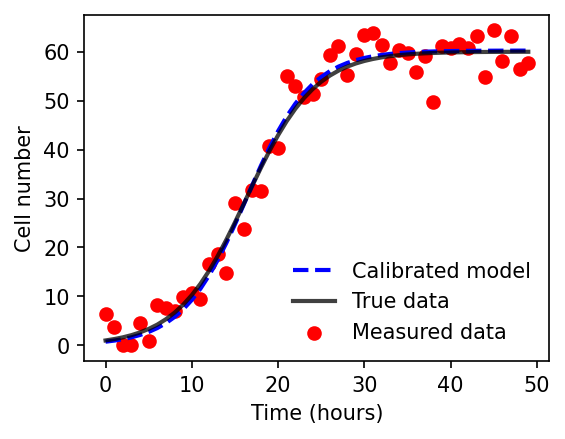

In [10]:
# Define parameters using maximum likelihood estimates (excluding initial condition)
parameters = (ml_r, ml_K)

# Solve the ODE model with maximum likelihood parameter estimates and maximum likelihood initial condition
y_ml = odeint(control_tumor, t=times, y0=ml_ic, args=parameters)

# Plot the calibrated model (including initial condition), true data, and observed data
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
plt.plot(times, y_ml, label='Calibrated model', linestyle='dashed', color='blue', linewidth=2.0)
plt.plot(times, y, label='True data', color='black', alpha=0.75, linewidth=2.0)
plt.scatter(times, yobs, label='Measured data', color='red')
plt.legend(frameon=False)
plt.xlabel('Time (hours)')
plt.ylabel('Cell number')
plt.savefig('ml_fit_ic.pdf', bbox_inches='tight', pad_inches=0.02, dpi=150)
plt.show()

## Bayesian approach
Given events A and B:
\begin{align*}
P(A,B)&=P(A|B)P(B);\\
P(A,B)&=P(B,A);\\
P(B,A)&=P(B|A)P(A);\\
P(A|B)P(B)&=P(B|A)P(A);\\
P(A|B)&=\frac{P(B|A)P(A)}{P(B)};
\end{align*}

Converting to probability densities $\pi$, if $A$ represents the parameter $\boldsymbol{\theta}$ of a model, and $B$ the observational data $\boldsymbol{D}$:
\begin{align*}
\underbrace{\pi(\boldsymbol{\theta}|\boldsymbol{D})}_{\text{posterior}}&=\frac{\overbrace{\pi(\boldsymbol{D}|\boldsymbol{\theta})}^{\text{likelihood}}\overbrace{\pi(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{\pi(\boldsymbol{D})}_{\text{evidence}}};\qquad \pi(\boldsymbol{D})=\int_\Theta\pi(\boldsymbol{D}|\boldsymbol{\theta})\pi(\boldsymbol{\theta})\, \text{d}\theta\\
\pi(\boldsymbol{\theta}|\boldsymbol{D})&\propto\pi(\boldsymbol{D}|\boldsymbol{\theta})\pi(\boldsymbol{\theta});\\
\log\pi(\boldsymbol{\theta}|\boldsymbol{D})&\propto\log\pi(\boldsymbol{D}|\boldsymbol{\theta})+\log\pi(\boldsymbol{\theta});
\end{align*}

In [11]:
def log_prior(theta, l_bound, u_bound):
    """
    Logarithm of the prior probability for the model parameters.

    Parameters:
        theta : array_like
            Model parameters.
        l_bound : array_like
            Lower bounds for the parameters.
        u_bound : array_like
            Upper bounds for the parameters.

    Returns:
        log_prior : float
            Logarithm of the prior probability.
    """
    for l, p, u in zip(l_bound, theta, u_bound):
        if not (l < p < u):
            return -np.inf  # Return negative infinity for invalid parameter values
    return 0.0

In [12]:
def log_probability(theta, times, data, l_bound, u_bound):
    """
    Logarithm of the joint probability of the model parameters and the data.

    Parameters:
        theta : array_like
            Model parameters.
        times : array_like
            Time points.
        data : array_like
            Observed data.
        l_bound : array_like
            Lower bounds for the parameters.
        u_bound : array_like
            Upper bounds for the parameters.

    Returns:
        log_probability : float
            Logarithm of the joint probability.
    """
    lp = log_prior(theta, l_bound, u_bound)  # Compute the logarithm of the prior probability
    if not np.isfinite(lp):
        return -np.inf  # Return negative infinity if prior probability is invalid
    return lp + log_likelihood_ic(theta, times, data)  # Return the sum of the logarithm of the prior and likelihood probabilities

In [13]:
# Define the size of the Markov Chain
chain_size = 10000

# Set the number of walkers for the Markov Chain Monte Carlo (MCMC) sampling
nwalkers = 2 * ndim

# Initialize the position array for walkers
pos = np.zeros((nwalkers, ndim))

# Generate initial positions for walkers within the specified bounds
for i in range(ndim):
    pos[:, i] = np.random.uniform(low=l_bound[i], high=u_bound[i], size=nwalkers)

# Create an EnsembleSampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(times, yobs, l_bound, u_bound))

# Run the MCMC sampler
out_cal = sampler.run_mcmc(pos, chain_size, progress=True)

100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 861.31it/s]


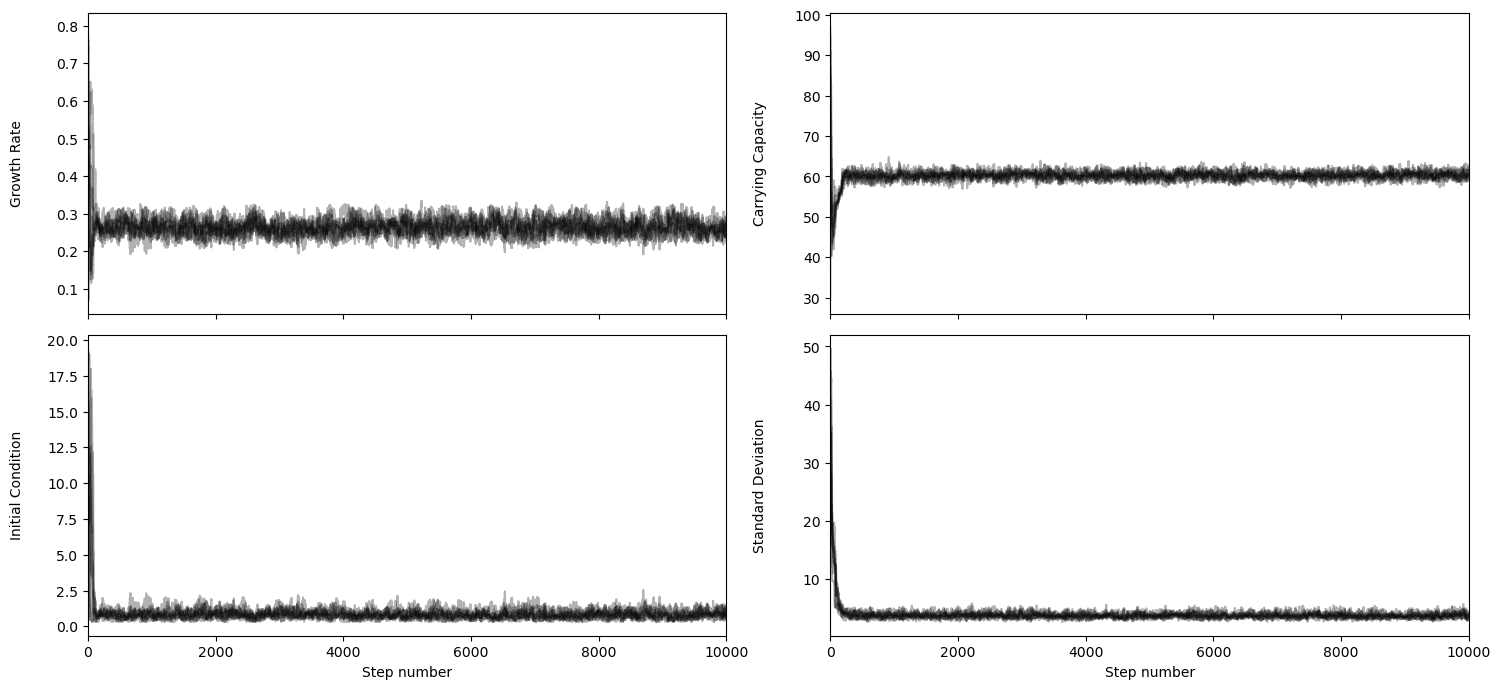

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), sharex=True)
axes.shape = (4)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number")
axes[-2].set_xlabel("Step number")
plt.tight_layout()
plt.show()

[67.49666051 84.02849823 61.7681865  93.36050477]
(72000, 4)


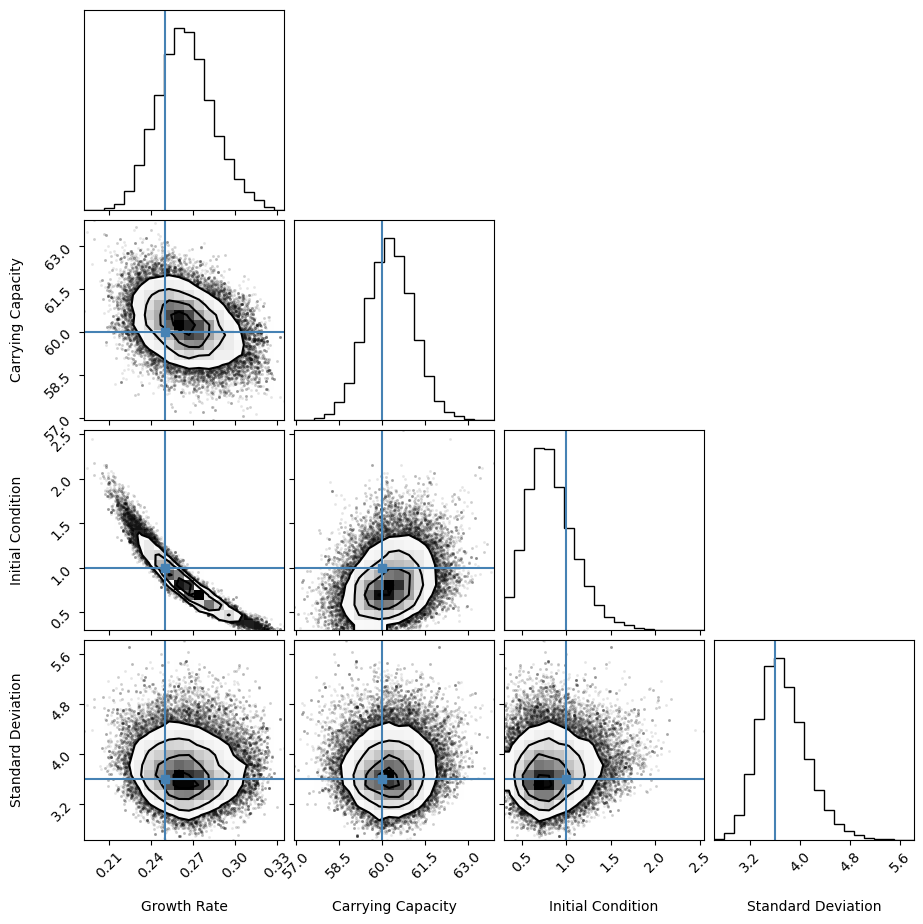

In [15]:
try:
    # Attempt to compute the autocorrelation time
    tau = sampler.get_autocorr_time()
    print(tau)
except:
    # If an exception occurs, print a message suggesting to increase the chain length
    print('You might increase the chain')

# Get the flat samples from the MCMC chain, discarding the first 1000 samples as burn-in
flat_samples = sampler.get_chain(discard=1000, flat=True)
print(flat_samples.shape)

# Generate a corner plot to visualize the joint and marginal distributions of the parameters
fig = corner.corner(flat_samples, labels=labels, truths=[true_r, true_K, true_ic, true_sigma])

In [16]:
def mean_ci(data, confidence=0.95):
    """
    Calculate the mean and confidence interval (CI) of a dataset.

    Parameters:
        data : array_like
            Dataset.
        confidence : float, optional
            Confidence level for the CI (default is 0.95).

    Returns:
        m : float
            Mean of the dataset.
        h : float
            Half-width of the confidence interval.
    """
    n = len(data)  # Number of samples in the dataset
    m = np.mean(data)  # Mean of the dataset
    se = scipy.stats.sem(data)  # Standard error of the mean
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)  # Half-width of the confidence interval
    return m, h

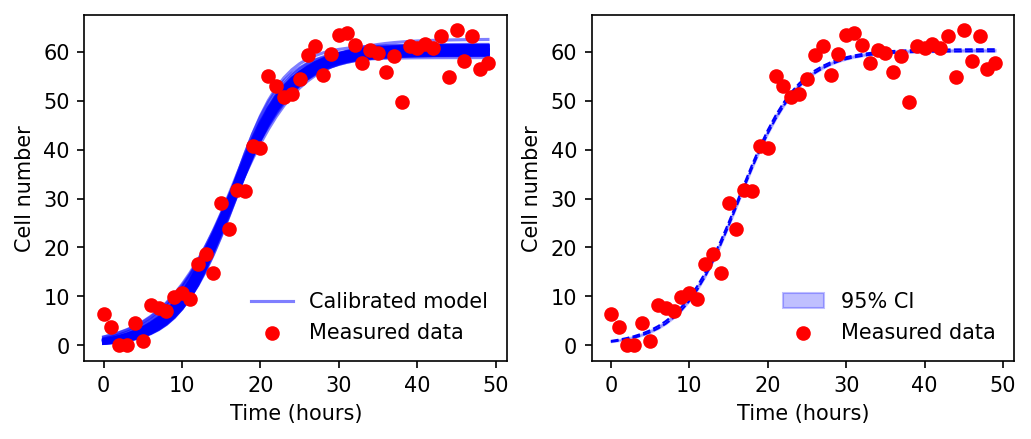

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3), dpi=150)
inds = np.random.randint(len(flat_samples), size=50)
create = True

# Plot individual model realizations
for ind in inds:
    parameters = tuple(flat_samples[ind][:-2])
    y_sp = odeint(control_tumor, t=times, y0=flat_samples[ind][-2], args=parameters)
    if create:
        A = y_sp
        create = False
    else:
        A = np.append(A, y_sp, 1)
    ax[0].plot(times, y_sp, 'blue', alpha=0.5)

# Plot the calibrated model
ax[0].plot(times, y_sp, label='Calibrated model', color='blue', alpha=0.5)
ax[0].scatter(times, yobs, zorder=100, label='Measured data', color='red')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Time (hours)')
ax[0].set_ylabel('Cell number')

# Calculate and plot the mean and confidence intervals
mean = []
ci = []
for b in range(A.shape[0]):
    m = mean_ci(A[b, :], 0.95)
    mean.append(m[0])
    ci.append(m[1])
ci = np.array(ci)
mean = np.array(mean)

# Fill the confidence interval
ax[1].fill_between(times, mean - ci, mean + ci, alpha=0.25, color='blue', label='95% CI')
ax[1].plot(times, mean - ci, linewidth=1, linestyle="--", color='blue')
ax[1].plot(times, mean + ci, linewidth=1, linestyle="--", color='blue')
ax[1].scatter(times, yobs, zorder=100, label='Measured data', color='red')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Time (hours)')
ax[1].set_ylabel('Cell number')

# Save the figure
plt.savefig('bc_fit_ic.pdf', bbox_inches='tight', pad_inches=0.02, dpi=150)
plt.show()

In [18]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])  # Calculate the 16th, 50th (median), and 84th percentiles
    q = np.diff(mcmc)  # Calculate the width of the confidence interval
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"  # LaTeX math expression template
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])  # Populate the template with parameter values and labels
    display(Math(txt))  # Display the LaTeX math expression

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [19]:
# Extract relevant information from the sampler
flat_ll = sampler.get_log_prob(flat=True)  # Log probabilities of the flat chain
flat_chain = sampler.get_chain(flat=True)  # Flattened chain of samples
max_pos = flat_ll.argmax(axis=0)  # Find the indices of the maximum log probabilities
best_pars = flat_chain[max_pos]  # Extract the parameter values corresponding to the maximum log probabilities

# Extract maximum likelihood estimates
ml_r, ml_K, ml_ic, ml_sigma = best_pars

# Print maximum likelihood estimates
print("Maximum likelihood estimates:")
print("Growth rate = %f" % ml_r)
print("Carrying capacity = %f" % ml_K)
print("Standard deviation = %f" % ml_sigma)
print("Initial condition = %f" % ml_ic)

# Calculate errors
error_r = 100 * abs(ml_r - true_r) / true_r
error_K = 100 * abs(ml_K - true_K) / true_K
error_sigma = 100 * abs(ml_sigma - true_sigma) / true_sigma
error_ic = 100 * abs(ml_ic - true_ic) / true_ic

# Print errors
print("Growth rate %% error = %f" % error_r)
print("Carrying capacity %% error = %f" % error_K)
print("Standard deviation %% error = %f" % error_sigma)
print("Initial condition %% error = %f" % error_ic)

Maximum likelihood estimates:
Growth rate = 0.266740
Carrying capacity = 60.235314
Standard deviation = 3.523796
Initial condition = 0.758106
Growth rate % error = 6.696038
Carrying capacity % error = 0.392190
Standard deviation % error = 2.116784
Initial condition % error = 24.189355
